# D2V Random Forest

## Load packages

In [82]:
## common packages
import os, sys, importlib
sys.path.append(os.getcwd())
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## machine learning packages
from sklearn import linear_model, cross_validation, metrics   #Additional scklearn functions
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import cross_val_score

#in house python 2 env
import GBT_library as GBT
GBT = reload(GBT)
#for save and load models
from sklearn.externals import joblib

## Read and clean

In [83]:
path="/Users/YIHUILI/Desktop/new_data/"
statement_vector_file = "final_statement_vectors_300_final.csv"
test_portion = 0.1  ## the portion of the data we want to isolate for testing
drop_middle_thrid = False
seed = 1

In [84]:
## read the data
vectors = pd.read_csv(path+statement_vector_file,index_col=0)
print("import size:",vectors.shape)

# filter out the Nan's and take/not to take the middle ROEs
if drop_middle_thrid:
    vectors_filtered = vectors[vectors['Label']!=2].dropna()
else:
    vectors_filtered = vectors.dropna()

## add 2 more columns of the sign of the change
vectors_filtered['ROE_excess_change_sign'] = vectors_filtered['ROE_excess_change']>0
vectors_filtered['ROE_change_sign'] = vectors_filtered['ROE_change']>0

## check if there is any missing data
assert vectors_filtered.isnull().sum().sum() == 0, "there are some na's in df vectors_filtered"

## how big is our super cleaned data
print("Total DF shape: ", vectors_filtered.shape)
m = len(vectors_filtered)

colnames = vectors_filtered.columns.values


('import size:', (28532, 331))
('Total DF shape: ', (21344, 333))


In [5]:
predictors_bm=['ROE_t-1', 'excess_ROE_t-1', 'ROE_change_t-1',
       'ROE_excess_change_t-1', 'ROE_t-2', 'excess_ROE_t-2',
       'ROE_change_t-2', 'ROE_excess_change_t-2', 'ROE_t-3',
       'excess_ROE_t-3', 'ROE_change_t-3', 'ROE_excess_change_t-3',
       'Label_top', 'Label_bottom', 'is_q1', 'is_q2', 'is_q3', 'is_q4']

In [6]:
## we augment the bm model by 300 features
predictors = np.append(colnames[1:301], predictors_bm)

## shuffle the data and take out 10% of data
np.random.seed(seed)
vectors_filtered_shuffled = vectors_filtered.iloc[np.random.permutation(len(vectors_filtered))].reset_index(drop=True)


test_data = vectors_filtered_shuffled.iloc[:int(m*test_portion)]
train_valid_data = vectors_filtered_shuffled.iloc[int(m*test_portion):]

## check if we slice correctly
assert len(test_data)+ len(train_valid_data) == m 

In [7]:
# we want to make sure the % of +'s and -'s are close
# otherwise we need to rebalance
y ='ROE_excess_change'
pos_ratio = ((vectors_filtered_shuffled[y]>0).sum()+0.0)/(len(vectors_filtered_shuffled)+0.0)
print("The positive ratio is {:.4f}".format(pos_ratio))


The positive ratio is 0.4943


## Benchmark


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.7670882 | Std - 0.005359292 | Min - 0.7589851 | Max - 0.774481


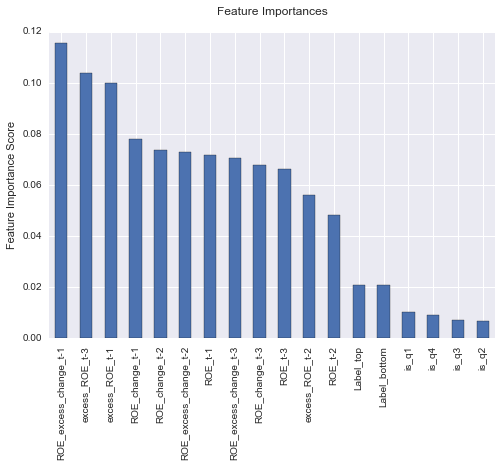

In [9]:
#train benchmanrk
y = 'ROE_excess_change_sign'
benchmark_train=train_valid_data[predictors_bm]
benchmark_train.shape

#bagging with all 18 benchmark features, Excess change ROE
rf_benchmark1 = RandomForestClassifier(random_state=10,max_features=18,n_estimators=100)
GBT.modelfit(rf_benchmark1, train_valid_data, predictors_bm, y)
y1_pred_benchmark=rf_benchmark1.predict(test_data[predictors_bm])


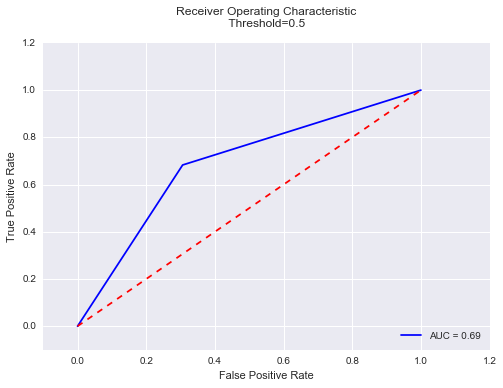

(0.6883889554978766, 1.0)

In [10]:
#look at OOS AUC
GBT.getAUC(rf_benchmark1,test_data,predictors_bm,y,threshold=0.5)

In [53]:
rf_benchmark1.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 18,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}

## glimps1 untuned


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.6846476 | Std - 0.008193619 | Min - 0.6763407 | Max - 0.696208


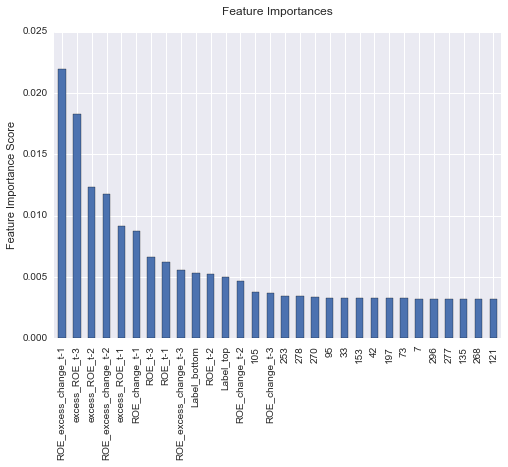

In [13]:
#brief try, using OOB Error as score
rf_glimps1 = RandomForestClassifier(random_state=10,n_estimators=100,oob_score=True)
GBT.modelfit(rf_glimps1, train_valid_data, predictors, y)

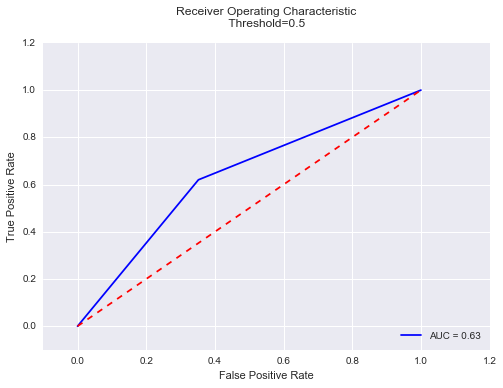

(0.63404656187828556, 1.0)

In [14]:
#look at OOS AUC
GBT.getAUC(rf_glimps1,test_data,predictors,y,threshold=0.5)

In [52]:
rf_glimps1.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': True,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}

## Tune model

In [16]:
##2.train max_feature
n_estimators= 150
min_samples_split = 0.001*len(vectors_filtered) ## make it 1% of the data
param_test2 = {'max_features':list(range(30,101,5))}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier( n_estimators = n_estimators, 
    min_samples_leaf = 30,
    min_samples_split=min_samples_split, max_depth=20,random_state=10, n_jobs = -1,criterion="entropy"),
    param_grid = param_test2, scoring='accuracy',n_jobs=-1,iid=False, cv=3)
gsearch2.fit(train_valid_data[predictors],train_valid_data[y])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.66622, std: 0.00385, params: {'max_features': 30},
  mean: 0.66705, std: 0.00556, params: {'max_features': 35},
  mean: 0.66804, std: 0.00556, params: {'max_features': 40},
  mean: 0.67017, std: 0.00332, params: {'max_features': 45},
  mean: 0.67168, std: 0.00484, params: {'max_features': 50},
  mean: 0.66944, std: 0.00414, params: {'max_features': 55},
  mean: 0.67225, std: 0.00641, params: {'max_features': 60},
  mean: 0.67220, std: 0.00760, params: {'max_features': 65},
  mean: 0.67251, std: 0.00234, params: {'max_features': 70},
  mean: 0.67678, std: 0.00527, params: {'max_features': 75},
  mean: 0.67439, std: 0.00283, params: {'max_features': 80},
  mean: 0.67694, std: 0.00240, params: {'max_features': 85},
  mean: 0.67590, std: 0.00553, params: {'max_features': 90},
  mean: 0.67683, std: 0.00395, params: {'max_features': 95},
  mean: 0.67751, std: 0.00124, params: {'max_features': 100}],
 {'max_features': 100},
 0.67751162961069056)

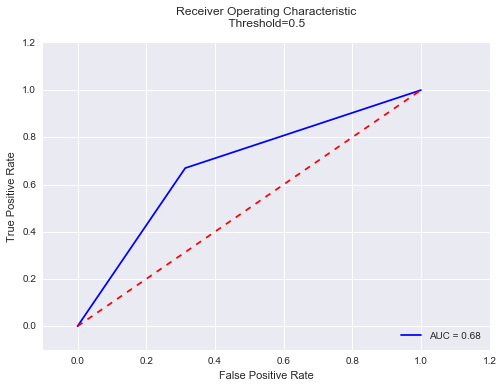

(0.67808491108798097, 1.0)

In [23]:
rf_1=gsearch2.best_estimator_
GBT.getAUC(rf_1,test_data,predictors,y,threshold=0.50)

In [51]:
rf_1.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 100,
 'max_leaf_nodes': None,
 'min_samples_leaf': 30,
 'min_samples_split': 21.344,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}

## Plot against benchmark

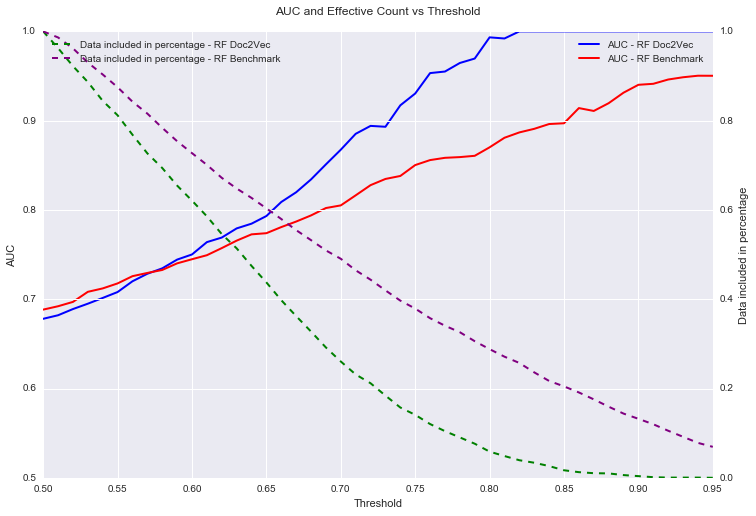

In [29]:
GBT.AUCvsThresholdPlot(rf_1,test_data,test_data,predictors,y,"RF Doc2Vec",rf_benchmark1, predictors_bm,y,"RF Benchmark")

#  ADV V6

## Read and clean

In [85]:
path="/Users/YIHUILI/Desktop/new_data/"
statement_vector_file2 = "final_BOW_FEATURES_ADV_v6.csv"
test_portion = 0.1  ## the portion of the data we want to isolate for testing
drop_middle_thrid = False
seed = 1


In [86]:
## read the data
vectors2 = pd.read_csv(path+statement_vector_file2,index_col=0)
print("import size:",vectors2.shape)

# filter out the Nan's and take/not to take the middle ROEs
if drop_middle_thrid:
    vectors_filtered2 = vectors2[vectors2['Label']!=2].dropna()
else:
    vectors_filtered2 = vectors2.dropna()

## add 2 more columns of the sign of the change
vectors_filtered2['ROE_excess_change_sign'] = vectors_filtered2['ROE_excess_change']>0
vectors_filtered2['ROE_change_sign'] = vectors_filtered2['ROE_change']>0

## check if there is any missing data
assert vectors_filtered2.isnull().sum().sum() == 0, "there are some na's in df vectors_filtered"

## how big is our super cleaned data
print("Total DF shape: ", vectors_filtered2.shape)
m = len(vectors_filtered2)

colnames2 = vectors_filtered2.columns.values


('import size:', (30001, 336))
('Total DF shape: ', (23005, 338))


In [87]:

predictors_bm=['ROE_t-1', 'excess_ROE_t-1', 'ROE_change_t-1',
       'ROE_excess_change_t-1', 'ROE_t-2', 'excess_ROE_t-2',
       'ROE_change_t-2', 'ROE_excess_change_t-2', 'ROE_t-3',
       'excess_ROE_t-3', 'ROE_change_t-3', 'ROE_excess_change_t-3',
       'Label_top', 'Label_bottom', 'is_q1', 'is_q2', 'is_q3', 'is_q4']

In [88]:
## we augment the bm model by 300 features
predictors2 = np.append(colnames2[3:303], predictors_bm)

## shuffle the data and take out 10% of data
np.random.seed(seed)
vectors_filtered_shuffled2 = vectors_filtered2.iloc[np.random.permutation(len(vectors_filtered2))].reset_index(drop=True)


test_data2 = vectors_filtered_shuffled2.iloc[:int(m*test_portion)]
train_valid_data2 = vectors_filtered_shuffled2.iloc[int(m*test_portion):]

## check if we slice correctly
assert len(test_data2)+ len(train_valid_data2) == m 

In [89]:
# we want to make sure the % of +'s and -'s are close
# otherwise we need to rebalance
y ='ROE_excess_change'
pos_ratio2 = ((vectors_filtered_shuffled2[y]>0).sum()+0.0)/(len(vectors_filtered_shuffled2)+0.0)
print("The positive ratio is {:.4f}".format(pos_ratio2))


The positive ratio is 0.4543


## Benchmark


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.8206801 | Std - 0.004739247 | Min - 0.8127325 | Max - 0.8258174


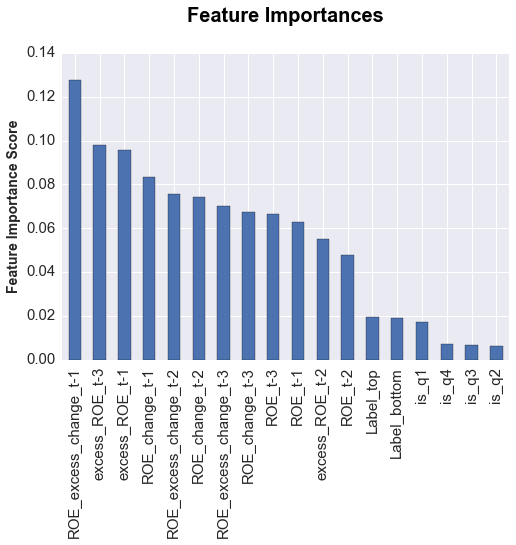

In [90]:
#train benchmanrk
y = 'ROE_excess_change_sign'
benchmark_train2=train_valid_data2[predictors_bm]
benchmark_train2.shape

#bagging with all 18 benchmark features, Excess change ROE
rf_benchmark2 = RandomForestClassifier(random_state=10,max_features=18,n_estimators=100)
GBT.modelfit(rf_benchmark2, train_valid_data2, predictors_bm, y)
y1_pred_benchmark2=rf_benchmark2.predict(test_data2[predictors_bm])


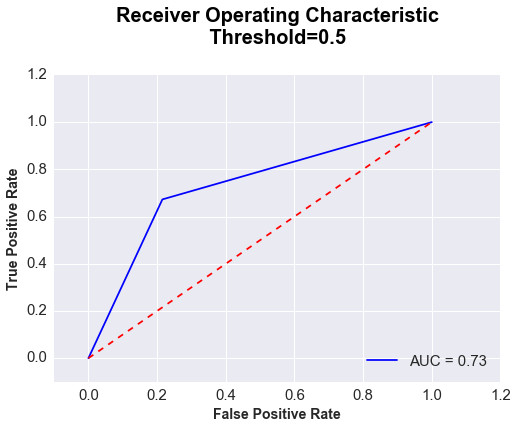

(0.72859362394593874, 1.0)

In [91]:
#look at OOS AUC
GBT.getAUC(rf_benchmark2,test_data2,predictors_bm,y,threshold=0.5)

In [92]:
rf_benchmark2.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 18,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}

## Brief try glimps2


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.7902563 | Std - 0.004617925 | Min - 0.7845064 | Max - 0.7957081


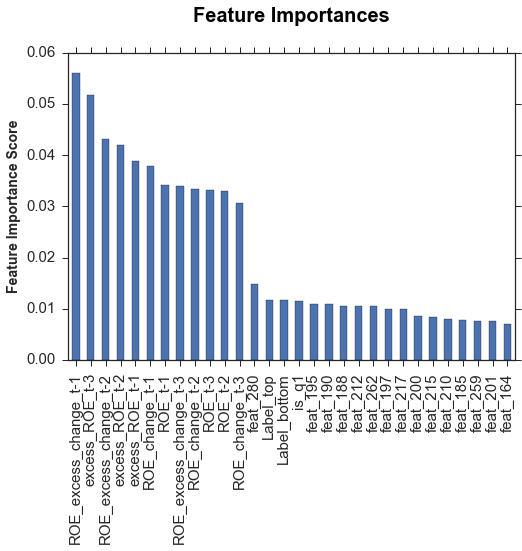

In [119]:
#brief try, using OOB Error as score
rf_glimps2 = RandomForestClassifier(random_state=10,n_estimators=100,oob_score=True)
GBT.modelfit(rf_glimps2, train_valid_data2, predictors2, y)

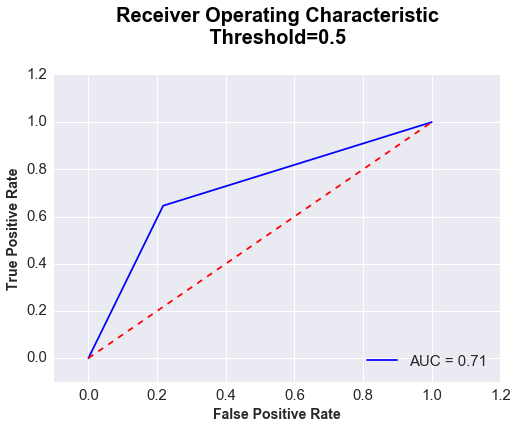

(0.71411360701347548, 1.0)

In [94]:
#look at OOS AUC
GBT.getAUC(rf_glimps2,test_data2,predictors2,y,threshold=0.5)

In [95]:
rf_glimps2.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': True,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}

## Train model

In [45]:
##2.train max_feature
n_estimators= 150
min_samples_split2 = 0.001*len(vectors_filtered2) ## make it 1% of the data
param_test2_2 = {'max_features':list(range(30,101,5))}
gsearch2_2 = GridSearchCV(estimator = RandomForestClassifier( n_estimators = n_estimators, 
    min_samples_leaf = 30,
    min_samples_split=min_samples_split2, max_depth=20,random_state=10, n_jobs = -1,criterion="entropy",oob_score=True),
    param_grid = param_test2_2, scoring='accuracy',n_jobs=-1,iid=False, cv=3)
gsearch2_2.fit(train_valid_data2[predictors2],train_valid_data2[y])
gsearch2_2.grid_scores_, gsearch2_2.best_params_, gsearch2_2.best_score_

([mean: 0.69384, std: 0.00210, params: {'max_features': 30},
  mean: 0.69534, std: 0.00205, params: {'max_features': 35},
  mean: 0.69911, std: 0.00303, params: {'max_features': 40},
  mean: 0.69848, std: 0.00338, params: {'max_features': 45},
  mean: 0.70215, std: 0.00095, params: {'max_features': 50},
  mean: 0.70254, std: 0.00308, params: {'max_features': 55},
  mean: 0.70379, std: 0.00294, params: {'max_features': 60},
  mean: 0.70563, std: 0.00361, params: {'max_features': 65},
  mean: 0.70355, std: 0.00103, params: {'max_features': 70},
  mean: 0.70640, std: 0.00359, params: {'max_features': 75},
  mean: 0.70548, std: 0.00408, params: {'max_features': 80},
  mean: 0.70625, std: 0.00291, params: {'max_features': 85},
  mean: 0.70698, std: 0.00120, params: {'max_features': 90},
  mean: 0.70828, std: 0.00309, params: {'max_features': 95},
  mean: 0.70645, std: 0.00142, params: {'max_features': 100}],
 {'max_features': 95},
 0.70828296141145819)

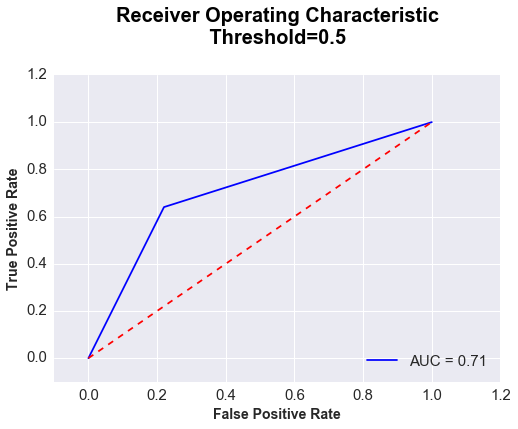

(0.70998861966681093, 1.0)

In [96]:
rf_2=gsearch2_2.best_estimator_
GBT.getAUC(rf_2,test_data2,predictors2,y,threshold=0.50)

In [48]:
rf_2.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 95,
 'max_leaf_nodes': None,
 'min_samples_leaf': 30,
 'min_samples_split': 23.005,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}

## Plot against benchmark

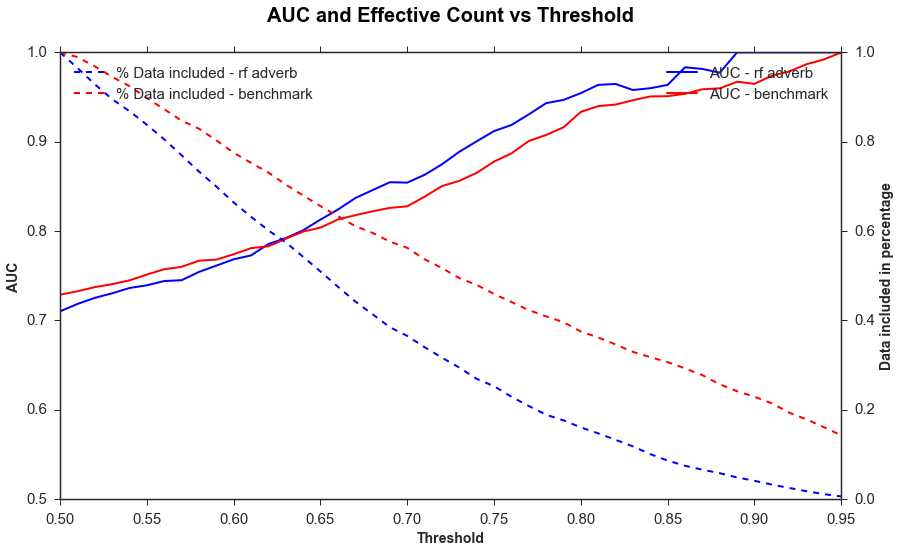

In [98]:
GBT.AUCvsThresholdPlot(rf_2,test_data2,predictors2,y, "rf adverb", rf_benchmark2,test_data2,predictors_bm,y,"benchmark")

## Compare D2V WITH ADV

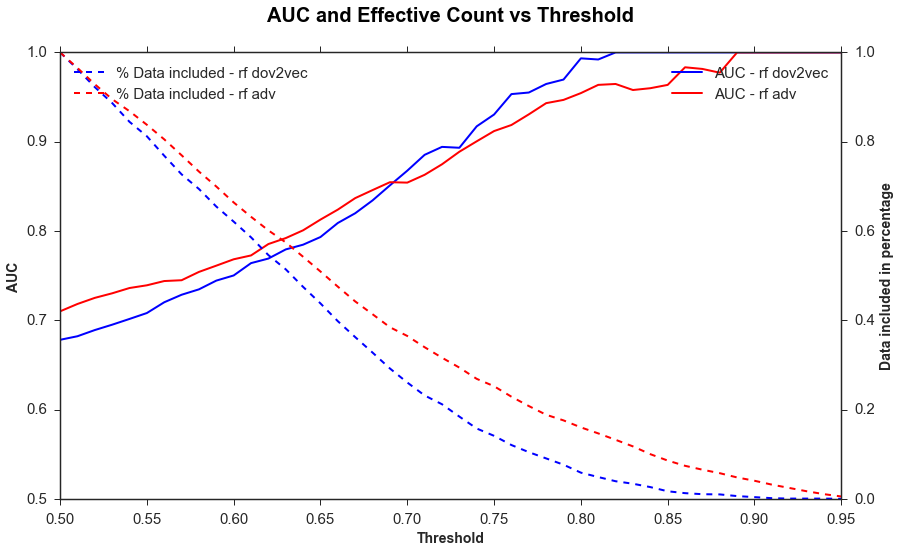

In [100]:
GBT.AUCvsThresholdPlot(rf_1,test_data,predictors,y, "rf dov2vec", rf_2,test_data2,predictors2,y,"rf adv")

# Constraint words

In [101]:
path="/Users/YIHUILI/Desktop/new_data/"
statement_vector_file3 = "final_BOW_FEATURES_CONSTRAINTS_v4.csv"
test_portion = 0.1  ## the portion of the data we want to isolate for testing
drop_middle_thrid = False
seed = 1


In [102]:
## read the data
vectors3 = pd.read_csv(path+statement_vector_file3,index_col=0)
print("import size:",vectors3.shape)

# filter out the Nan's and take/not to take the middle ROEs
if drop_middle_thrid:
    vectors_filtered3 = vectors3[vectors3['Label']!=2].dropna()
else:
    vectors_filtered3 = vectors3.dropna()

## add 2 more columns of the sign of the change
vectors_filtered3['ROE_excess_change_sign'] = vectors_filtered3['ROE_excess_change']>0
vectors_filtered3['ROE_change_sign'] = vectors_filtered3['ROE_change']>0

## check if there is any missing data
assert vectors_filtered3.isnull().sum().sum() == 0, "there are some na's in df vectors_filtered"

## how big is our super cleaned data
print("Total DF shape: ", vectors_filtered3.shape)
m = len(vectors_filtered3)

colnames3 = vectors_filtered3.columns.values


('import size:', (30001, 337))
('Total DF shape: ', (23005, 339))


In [103]:
predictors_bm=['ROE_t-1', 'excess_ROE_t-1', 'ROE_change_t-1',
       'ROE_excess_change_t-1', 'ROE_t-2', 'excess_ROE_t-2',
       'ROE_change_t-2', 'ROE_excess_change_t-2', 'ROE_t-3',
       'excess_ROE_t-3', 'ROE_change_t-3', 'ROE_excess_change_t-3',
       'Label_top', 'Label_bottom', 'is_q1', 'is_q2', 'is_q3', 'is_q4']

In [104]:
#colnames3[4:304]

In [105]:
## we augment the bm model by 300 features
predictors3 = np.append(colnames3[4:304], predictors_bm)

## shuffle the data and take out 10% of data
np.random.seed(seed)
vectors_filtered_shuffled3 = vectors_filtered3.iloc[np.random.permutation(len(vectors_filtered3))].reset_index(drop=True)


test_data3 = vectors_filtered_shuffled3.iloc[:int(m*test_portion)]
train_valid_data3 = vectors_filtered_shuffled3.iloc[int(m*test_portion):]

## check if we slice correctly
assert len(test_data3)+ len(train_valid_data3) == m 

In [106]:
# we want to make sure the % of +'s and -'s are close
# otherwise we need to rebalance
y ='ROE_excess_change'
pos_ratio3 = ((vectors_filtered_shuffled3[y]>0).sum()+0.0)/(len(vectors_filtered_shuffled3)+0.0)
print("The positive ratio is {:.4f}".format(pos_ratio3))

The positive ratio is 0.4543



Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.8206801 | Std - 0.004739247 | Min - 0.8127325 | Max - 0.8258174


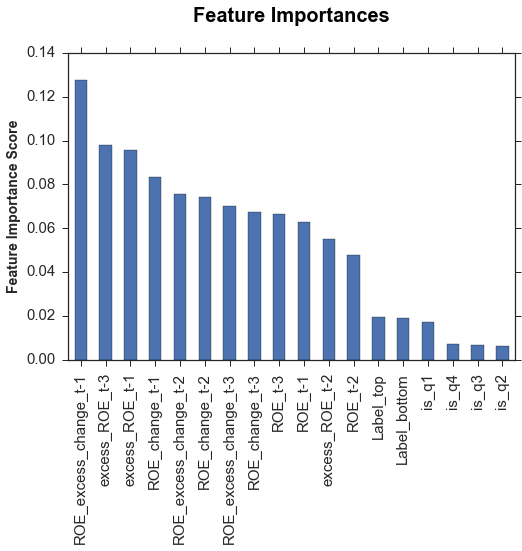

In [107]:
#train benchmanrk
y = 'ROE_excess_change_sign'
benchmark_train3=train_valid_data3[predictors_bm]
benchmark_train3.shape

#bagging with all 18 benchmark features, Excess change ROE
rf_benchmark3 = RandomForestClassifier(random_state=10,max_features=18,n_estimators=100)
GBT.modelfit(rf_benchmark3, train_valid_data3, predictors_bm, y)
y1_pred_benchmark3=rf_benchmark3.predict(test_data3[predictors_bm])


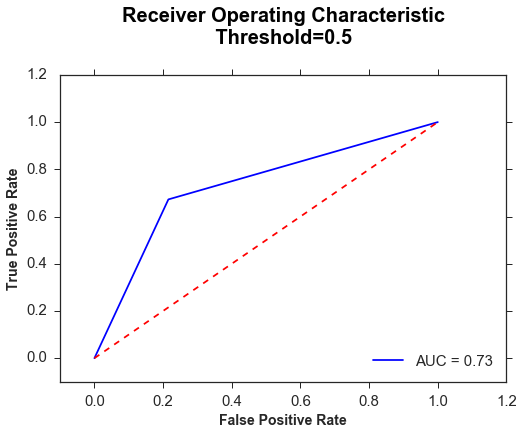

(0.72859362394593874, 1.0)

In [110]:
#look at OOS AUC
GBT.getAUC(rf_benchmark3,test_data3,predictors_bm,y,threshold=0.5)

In [111]:
rf_benchmark3.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 18,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.8057287 | Std - 0.003461676 | Min - 0.8030042 | Max - 0.8121471


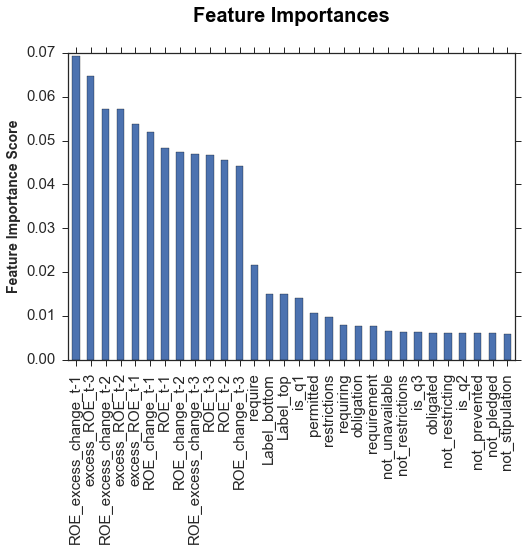

In [118]:
#brief try, using OOB Error as score
rf_glimps3 = RandomForestClassifier(random_state=10,n_estimators=100,oob_score=True)
GBT.modelfit(rf_glimps3, train_valid_data3, predictors3, y)

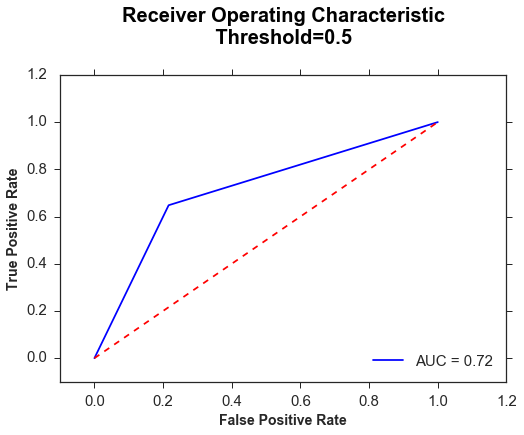

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': True,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}

In [112]:
#look at OOS AUC
GBT.getAUC(rf_glimps3,test_data3,predictors3,y,threshold=0.5)
rf_glimps3.get_params()

# train model

In [74]:
##2.train max_feature
n_estimators= 150
min_samples_split3 = 0.001*len(vectors_filtered3) ## make it 1% of the data
param_test3_3 = {'max_features':list(range(30,101,5))}
gsearch3_3 = GridSearchCV(estimator = RandomForestClassifier( n_estimators = n_estimators, 
    min_samples_leaf = 30,
    min_samples_split=min_samples_split3, max_depth=20,random_state=10, n_jobs = -1,criterion="entropy",oob_score=True),
    param_grid = param_test3_3, scoring='accuracy',n_jobs=-1,iid=False, cv=3)
gsearch3_3.fit(train_valid_data3[predictors3],train_valid_data3[y])
gsearch3_3.grid_scores_, gsearch3_3.best_params_, gsearch3_3.best_score_

([mean: 0.69263, std: 0.00388, params: {'max_features': 30},
  mean: 0.69606, std: 0.00272, params: {'max_features': 35},
  mean: 0.69727, std: 0.00244, params: {'max_features': 40},
  mean: 0.70012, std: 0.00183, params: {'max_features': 45},
  mean: 0.70118, std: 0.00335, params: {'max_features': 50},
  mean: 0.70418, std: 0.00170, params: {'max_features': 55},
  mean: 0.70249, std: 0.00286, params: {'max_features': 60},
  mean: 0.70442, std: 0.00426, params: {'max_features': 65},
  mean: 0.70476, std: 0.00357, params: {'max_features': 70},
  mean: 0.70524, std: 0.00390, params: {'max_features': 75},
  mean: 0.70664, std: 0.00254, params: {'max_features': 80},
  mean: 0.70746, std: 0.00101, params: {'max_features': 85},
  mean: 0.70635, std: 0.00115, params: {'max_features': 90},
  mean: 0.70867, std: 0.00455, params: {'max_features': 95},
  mean: 0.71050, std: 0.00384, params: {'max_features': 100}],
 {'max_features': 100},
 0.7105046446722536)

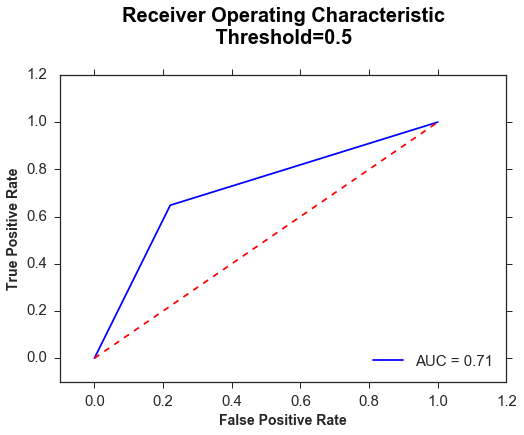

(0.71354459035401729, 1.0)

In [113]:
rf_3=gsearch3_3.best_estimator_
GBT.getAUC(rf_3,test_data3,predictors3,y,threshold=0.50)

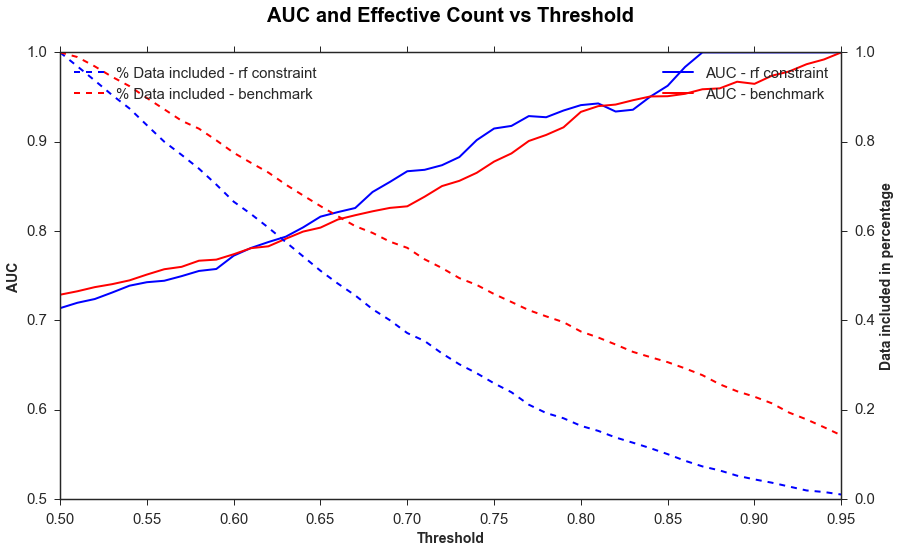

In [114]:
GBT.AUCvsThresholdPlot(rf_3,test_data3,predictors3,y, "rf constraint", rf_benchmark3,test_data3,predictors_bm,y,"benchmark")

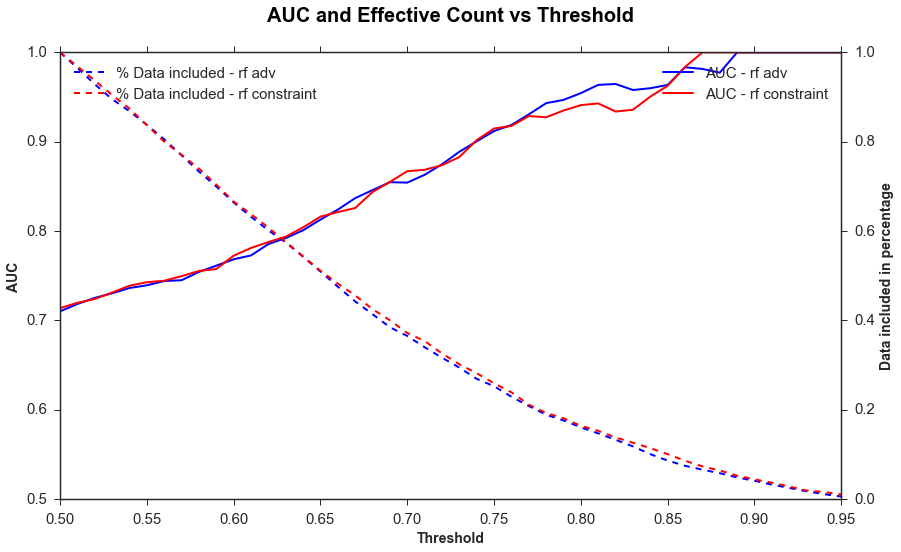

In [116]:
#plot against adv
GBT.AUCvsThresholdPlot(rf_2,test_data2,predictors2,y,"rf adv", rf_3,test_data3,predictors3,y,"rf constraint")

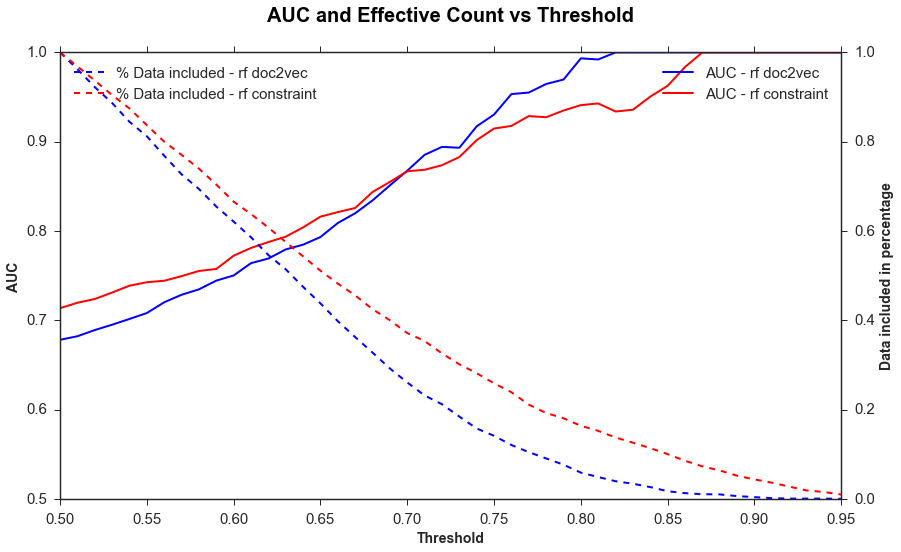

In [117]:
#plot against doc2vec
GBT.AUCvsThresholdPlot(rf_1,test_data,predictors,y, "rf doc2vec", rf_3,test_data3,predictors3,y,"rf constraint")